# Triplet Loss

In the previous tutorial, we discussed how to compare two inputs using a Siamese network. We used the contrastive loss function to train the network so that the embeddings of similar inputs are close together, while the embeddings of dissimilar inputs are far apart. However, the contrastive loss only considers pairwise relationships and does not take into account the relative distances between multiple embeddings.

Triplet loss addresses this limitation by considering triplets of embeddings, each consisting of three elements: an anchor, a positive, and a negative. The anchor and positive embeddings are from similar inputs, while the anchor and negative embeddings are from dissimilar inputs. The objective is to push the negative further away from the anchor than the positive, regardless of the absolute distances between the anchor-positive and anchor-negative pairs. This structured comparison allows the model to learn more discriminative and robust embeddings, which is particularly useful in tasks like face recognition and image retrieval.

In this tutorial, we will implement a Siamese Network to compare images of handwritten digits from the MNIST dataset. We will train the network using the triplet loss function originally proposed by Schroff *et al* in 2015, together with the online triplet mining strategies proposed by Hermans *et al* in 2017.

**Reference:** https://omoindrot.github.io/triplet-loss

![Triplet Loss](pics/metric-losses.png)

## What is triplet loss?

Triplet loss is a supervised loss function that operates on sets of three examples, which are referred to as triplets. Each triplet consists of the following elements.
- **Anchor** - A sample from the dataset.
- **Positive** - A sample that is similar to the anchor.
- **Negative** - A sample that is dissimilar to the anchor.

The objective of triplet loss is to ensure that the anchor-positive distance is smaller than the anchor-negative distance by a margin. Formally, the loss function is defined by the following formula.

$$
\mathcal{L}_{\rm triplet}(z_a, z_p, z_n) = \max(0, \|z_a - z_p\| - \|z_a - z_n\| + m)
$$

Where:
- $z_a$, $z_p$, and $z_n$ are the embeddings of the anchor, positive, and negative samples, respectively.
- $m$ is the margin that defines the minimum relative separation between the positive and negative pairs.

Minimizing the triplet loss makes the anchor-positive distance small and the anchor-negative distance large. As soon as the anchor-negative distance is greater than the anchor-positive distance by at least the margin, the loss becomes zero, and the model stops updating the three embeddings.

![Triplet Loss](pics/triplet-loss.png)

## Triplet mining

In practice, training a Siamese network with triplet loss can be challenging due to the vast number of possible triplets in a dataset. A naïve approach would involve generating all possible triplets, but this is extremely inefficient since many triplets will already satisfy the triplet constraint, making their loss close to zero and providing minimal gradient updates. A more efficient approach is to select informative triplets that violate the triplet constraint and provide meaningful gradient updates.


![Triplet Mining](pics/triplet-mining.png)

### Mining strategies

Selecting the most informative triplets is crucial for training a Siamese network effectively. There are several strategies that can be used to generate triplets during training.

- **Random mining**: Randomly select triplets from the dataset. This approach is simple but inefficient since most triplets will be easy and provide minimal gradient updates. Not recommended in practice.

- **Hard mining**: Select triplets where the negative is closer to the anchor than the positive, meaning $\|z_a - z_n\| < \|z_a - z_p\|$. This strategy focuses on the hardest triplets, which are the most informative for learning. However, using only hard triplets can lead to slow convergence or instability if the hardest negatives are too challenging at the start of training.

- **Semi-hard mining**: Select triplets where the negative is further from the anchor than the positive, but still within a margin of the positive, meaning $\|z_a - z_p\| < \|z_a - z_n\| < \|z_a - z_p\| + m$. These triplets provide meaningful gradients while avoiding instability from extreme hard negatives. Many successful models, such as FaceNet, rely on semi-hard triplet mining for stable and effective training.

### Online mining

Since scanning the entire dataset at every epoch is impractical, triplet mining is often performed "online" after a mini-batch is sampled. This approach selects triplets from the current mini-batch, which is more computationally efficient and provides fresh triplets at each iteration. There are essentially two ways to perform online triplet mining.

- **Batch-All Mining**: Select all valid triplets within the mini-batch, except for the easy triplets resulting in a loss of zero. In a batch of size $B=CK$ composed of $C$ classes and $K$ samples per class, there are $CK$ anchors, $K-1$ possible positives per anchor, and $CK-K$ possible negatives per anchor. Therefore, there are $CK(K-1)(CK-K)$ valid triplets in a batch, from which only the hard or semi-hard triplets are selected. This approach ensures that no informative triplet is ignored, but can be computationally expensive for large batch sizes.

- **Batch-Hard Mining.** For each sample in the batch, select the hardest positive (biggest distance from the anchor) and the hardest negative (smallest distance from the anchor) within the batch. This ensures that every triplet contributes a strong gradient update and helps the network focus on challenging cases. A large batch size is recommended to ensure a diverse set of triplets.

### Best practices

Training a network with triplet loss can be challenging due to triplet selection, slow convergence, and sensitivity to hyperparameters. Below are best practices that address these pitfalls and provide actionable solutions for stable and efficient training.

- Triplet mining greatly influences the training process. Semi-hard triplets provide a good balance between informative gradients and stable convergence. Hard triplets are useful too, but may cause instability if used exclusively. Online triplet mining is recommended for efficiency and fresh triplets at each iteration.

- As training progresses, the network gets better at embedding the data, and finding hard or semi-hard triplets becomes more difficult. Monitoring the fraction of hard and semi-hard triplets can provide insights into the training process. If the fraction of hard triplets is too high, the margin may be too small, and if the fraction of semi-hard triplets is too high, the margin may be too large.

- The margin is a critical hyperparameter that may slow down convergence if set too high or make the training unstable if set too low. As a rule of thumb, the margin should be selected so that no more than 50% of triplets are easy at the beginning of training.

- Small batches contain limited negatives, leading to poor hard-triplet selection. Larger batch sizes of 512 samples improve the quality of online triplet mining. Moreover, batches with multiple examples per class ensure enough intra-class and inter-class diversity.

- Raw embeddings can have varying scales, making distance calculations unstable. Applying L2 normalization to embeddings stabilizes training and simplifies the choice of the margin, as distances are now in the range [0, 2].

## PyTorch implementation

Let's implement the triplet loss function in PyTorch. The approach can vary depending on the type of labels available. In this tutorial, we assume that we have a classification dataset. Hence, we create a custom loss function that takes a batch of embeddings and their corresponding class labels as input. This implementation is inspired by the [recipe](https://github.com/pytorch/vision/tree/main/references/similarity) included in TorchVision.

```{note}
All the functions shown below are defined in the file [`triplet.py`](../../code/triplet.py).
```

In [1]:
import torch
import sys
sys.path.append('../../code')  # folder with triplet.py
from display import print_code
from triplet import TripletLoss, triplet_loss_batch_hard, triplet_loss_batch_all, get_triplets, get_pairs

### Helper function: `get_pairs()`

We start by defining a helper function `get_pairs()` that generates all possible positive and negative pairs within a batch. This function takes a 1D tensor of class labels and returns the following tensors.

  - **Positive pairs.** A boolean matrix of shape (N, N), where each element (i, j) is true if `labels[i] == labels[j]` and `i != j`. The self-pairs (i, i) are not selected. If (i, j) is true, then (j, i) is also true.
    
  - **Negative pairs.** A boolean matrix of shape (N, N), where each element (i, j) is true if `labels[i] != labels[j]`. If (i, j) is true, then (j, i) is also true.

Note that the function uses broadcasting to compare all pairs of labels efficiently.

In [2]:
print_code('get_pairs')

def get_pairs(labels: torch.IntTensor) -> tuple[torch.BoolTensor, torch.BoolTensor]:
    """
    Get positive and negative pairs from labels and return them as boolean matrices.

    Args
        - labels: 1D tensor containing class labels

    Returns
        - positive: 2D boolean tensor where positive[i, j] = True if labels[i] == labels[j] and i != j
        - negative: 2D boolean tensor where negative[i, j] = True if labels[i] != labels[j]
    """
    positive = labels.unsqueeze(0) == labels.unsqueeze(1)
    positive.fill_diagonal_(False)
    negative = labels.unsqueeze(0) != labels.unsqueeze(1)
    return positive, negative

Let's make a simple test to verify the correctness of the function.

In [3]:
labels = torch.tensor([0, 0, 1, 2, 2, 3, 3, 3])

positive, negative = get_pairs(labels)

In [4]:
print("Matrix of positive pairs:")
print(positive.int().numpy())
print()
print("Matrix of negative pairs:")
print(negative.int().numpy())

Matrix of positive pairs:
[[0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 0 1 0 1]
 [0 0 0 0 0 1 1 0]]

Matrix of negative pairs:
[[0 0 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1]
 [1 1 1 0 0 1 1 1]
 [1 1 1 0 0 1 1 1]
 [1 1 1 1 1 0 0 0]
 [1 1 1 1 1 0 0 0]
 [1 1 1 1 1 0 0 0]]


### Helper function: `get_triplets()`

Next, we define a helper function `get_triplets()` that generates all valid triplets within a batch. This function takes a 1D tensor of class labels as input and returns the following tensors.

  - **Anchors.** A 1D tensor of shape (N,) containing the indices of the anchor samples.
    
  - **Positives.** A 1D tensor of shape (N,) containing the indices of the positive samples.
    
  - **Negatives.** A 1D tensor of shape (N,) containing the indices of the negative samples.

The function first generates all positive and negative pairs using the `get_pairs()` function. It then combines the positive and negative matrices via broadcasting to form a 3D tensor of shape (N, N, N). Each element (i, j, k) is True if the triplet (i, j, k) is valid, meaning `i != j` and `labels[i] == labels[j]` and `labels[i] != labels[k]`. Finally, the function extracts the indices of the valid triplets from the 3D tensor.

In [5]:
print_code('get_triplets')

def get_triplets(labels: torch.IntTensor) -> tuple[torch.IntTensor, torch.IntTensor, torch.IntTensor]:
    """
    Get all valid triplets (i, j, k) where i != j and labels[i] == labels[j] and labels[i] != labels[k]

    Args
        - labels: 1D tensor containing class labels

    Returns
        - anchor: 1D tensor containing indices of anchor samples
        - positive: 1D tensor containing indices of positive samples
        - negative: 1D tensor containing indices of negative samples
    """
    i_equal_j, i_not_equal_k = get_pairs(labels)
    triplets = i_equal_j.unsqueeze(2) & i_not_equal_k.unsqueeze(1)
    assert torch.any(triplets), "No valid triplets found"
    return torch.nonzero(triplets, as_tuple=True)

Let's make a simple test to verify the correctness of the function.

In [6]:
labels = torch.tensor([0, 0, 1, 2, 2, 3, 3, 3])

anchor, positive, negative = get_triplets(labels)

In [7]:
for c in range(labels.numel()):
    mask = anchor == c
    tuples = zip(anchor[mask], positive[mask], negative[mask])
    print("Triplets with anchor", c)
    print("  ", ", ".join(f"({i} {j} {k})" for i, j, k in tuples))

Triplets with anchor 0
   (0 1 2), (0 1 3), (0 1 4), (0 1 5), (0 1 6), (0 1 7)
Triplets with anchor 1
   (1 0 2), (1 0 3), (1 0 4), (1 0 5), (1 0 6), (1 0 7)
Triplets with anchor 2
   
Triplets with anchor 3
   (3 4 0), (3 4 1), (3 4 2), (3 4 5), (3 4 6), (3 4 7)
Triplets with anchor 4
   (4 3 0), (4 3 1), (4 3 2), (4 3 5), (4 3 6), (4 3 7)
Triplets with anchor 5
   (5 6 0), (5 6 1), (5 6 2), (5 6 3), (5 6 4), (5 7 0), (5 7 1), (5 7 2), (5 7 3), (5 7 4)
Triplets with anchor 6
   (6 5 0), (6 5 1), (6 5 2), (6 5 3), (6 5 4), (6 7 0), (6 7 1), (6 7 2), (6 7 3), (6 7 4)
Triplets with anchor 7
   (7 5 0), (7 5 1), (7 5 2), (7 5 3), (7 5 4), (7 6 0), (7 6 1), (7 6 2), (7 6 3), (7 6 4)


### Batch-all mining

In the batch-all mining strategy, the loss function is computed for all valid triplets within a batch, except for the easy triplets (for which the loss is zero). The function takes a batch of embeddings and their corresponding class labels as input, and returns the average triplet loss over all hard and semi-hard triplets. Here are the steps involved in its implementation.
 - Generate all possible triplets using the `get_triplets()` function.
 - Compute the pairwise distances between all embeddings in the batch.
 - Select the anchor-positive and anchor-negative distances using the triplet indices.
 - Compute the loss of each triplet.
    - No need to apply `max(0, ...)` at this stage, as we will filter out the easy triplets later.
 - Remove the easy triplets by filtering out the negative loss values. 
    - This is why we skipped `max(0, ...)` in the previous step.
 - Return the mean of the remaining loss values, which correspond to semi-hard and hard triplets.

In [8]:
print_code('batch_all')

def triplet_loss_batch_all(embeddings: torch.FloatTensor, labels: torch.IntTensor, margin: float):

    # all triplets in the batch
    anchor, positive, negative = get_triplets(labels)

    # pairwise distance between embeddings
    pairwise_dist = torch.cdist(embeddings, embeddings, p=2)

    # distance between anchor-positive and anchor-negative pairs
    positive_dist = pairwise_dist[anchor, positive]
    negative_dist = pairwise_dist[anchor, negative]

    # triplet loss
    loss = positive_dist - negative_dist + margin
    
    # removal of easy triplets
    loss = loss[loss > 0]

    return loss.mean()

### Batch-hard mining

In the batch-hard mining strategy, the loss function is computed over a number of triplets equal to the batch size. The function takes a batch of embeddings and their corresponding class labels as input, and returns the average triplet loss over the triplets generated as follows. For each sample in the batch, we select it as the anchor of a triplet, then we find the positive with the largest distance and the negative with the smallest distance. Here are the steps involved in the implementation.
 - Generate all positive pairs and negative pairs using the `get_pairs()` function.
 - Compute the pairwise distances between all embeddings in the batch.
 - Select the hardest positive and hardest negative for each anchor.
 - Compute the loss of each triplet and return the mean value.

In [9]:
print_code('batch_hard')

def triplet_loss_batch_hard(embeddings: torch.FloatTensor, labels: torch.IntTensor, margin: float):

    # all pairs in the batch
    positive, negative = get_pairs(labels)

    # pairwise distance between embeddings
    pairwise_dist = torch.cdist(embeddings, embeddings, p=2)

    # hardest positive for each anchor
    anchor_positive_dist  = pairwise_dist.where(positive, 0)
    hardest_positive_dist = anchor_positive_dist.amax(dim=1)

    # hardest negative for each anchor
    anchor_negative_dist  = pairwise_dist.where(negative, torch.inf)
    hardest_negative_dist = anchor_negative_dist.amin(dim=1)

    # triplet loss
    loss = torch.relu(hardest_positive_dist - hardest_negative_dist + margin)

    return loss.mean()

### Module `TripletLoss`

Finally, we define a custom `TripletLoss` class that encapsulates the triplet loss function. The constructor takes the margin and a mining strategy as input. The `forward()` method takes a batch of embeddings and their corresponding class labels as input and returns the average triplet loss over the batch.

In [10]:
print_code('TripletLoss')

class TripletLoss(torch.nn.Module):

    def __init__(self, margin: float, batch_all: bool = False):
        super().__init__()
        self.margin = margin
        self.loss_fn = triplet_loss_batch_all if batch_all else triplet_loss_batch_hard

    def forward(self, embeddings: torch.FloatTensor, labels: torch.IntTensor):
        assert embeddings.size(0) == labels.size(0), "Number of embeddings and labels must match"
        assert embeddings.dim() == 2, "Embeddings must be 2D"
        assert labels.dim() == 1, "Labels must be 1D"
        return self.loss_fn(embeddings, labels, self.margin)

## Training with triplet loss

Now, let's train a Siamese network using triplet loss on the MNIST dataset. Since our implementation of triplet loss has the same signature of the loss functions for classification, we can reuse the same training loop as before. We import the necessary modules below.

In [11]:
import sys
sys.path.append('../../code')  # folder with train.py and triplet.py

from train import trainer
from eval import Evaluator
from triplet import TripletLoss

In [12]:
import torch
from torchvision.transforms import v2
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

### Dataset

First, we load the MNIST dataset with a minimal preprocessing pipeline that converts images to tensors.

In [13]:
preprocess = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

train_ds = MNIST('.data', train=True,  download=True, transform=preprocess)
test_ds  = MNIST('.data', train=False, download=True, transform=preprocess)

### Model

Next, we define a Siamese network that is similar to the one used in the previous tutorial. The only difference is that we add an option to normalize the network output. This prevents the embeddings from having varying scales by forcing them to lie on the unit hypersphere.

In [14]:
class EmbeddingNet(torch.nn.Module):

    def __init__(self, out_dim, normalize=True):
        super().__init__()
        self.backbone = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(128, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )
        self.neck = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(256 * 3 * 3, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, out_dim),
        )
        self.normalize = normalize

    def forward(self, x):
        x = self.backbone(x)
        x = self.neck(x)
        if self.normalize:
            x = torch.nn.functional.normalize(x, dim=1)
        return x

### Setup

Then, we instantiate the model, loss function, optimizer, and data loaders. We use the batch-all mining strategy with a margin of 0.2 and a large batch size of 512 to ensure a diverse set of triplets.

In [15]:
model = EmbeddingNet(50, normalize=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

loss_fn = TripletLoss(margin=0.2, batch_all=True)
loader = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)

### Training loop

Finally, we train the model for a few epochs.

In [16]:
history = trainer(model, loader, loss_fn, optimizer, epochs=5)

===== Training on cuda device =====


Epoch  5/5: 100%|██████████| 118/118 [00:13<00:00,  9.06it/s, train_loss=0.141]


We plot the train loss recorded during training.

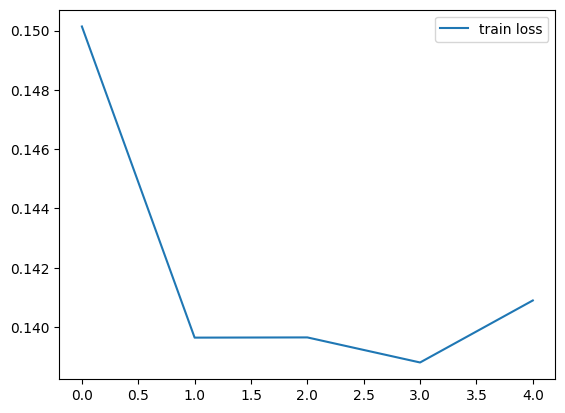

In [17]:
plt.plot(history['train'], label='train loss')
plt.legend()
plt.show()

## Evaluation

To evaluate the network using k-NN search or t-SNE visualization, we start by generating embeddings for both the train and test set. 

In [18]:
def get_embeddings(model: torch.nn.Module, 
                   data: torch.utils.data.Dataset | torch.utils.data.DataLoader,
                   batch_size: int = 64
                   ) -> tuple[torch.FloatTensor, torch.IntTensor]:
    
    if isinstance(data, torch.utils.data.Dataset):
        data = torch.utils.data.DataLoader(data, batch_size)
    elif not isinstance(data, torch.utils.data.DataLoader):
        raise ValueError('data must be a Dataset or a DataLoader')

    model_device = next(model.parameters()).device
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
    
    model = model.to(device)
    model.eval()

    embeddings = []
    labels = []

    for x, l in loader:
        x = x.to(device)
        with torch.inference_mode():
            y = model(x)
        embeddings.append(y.cpu())
        labels.append(l)

    model = model.to(model_device)

    return torch.cat(embeddings), torch.cat(labels)

In [19]:
train_embeddings, train_labels = get_embeddings(model, train_ds)
test_embeddings,  test_labels  = get_embeddings(model, test_ds)

### k-NN search

We perform a k-NN search using the embeddings generated by the network.

In [20]:
# Train a simple k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
knn.fit(train_embeddings.numpy(), train_labels.numpy())

# Evaluate
preds = knn.predict(test_embeddings.numpy())
knn_accuracy = accuracy_score(test_labels.numpy(), preds)

print(f"k-NN Accuracy: {knn_accuracy:.2%}")

k-NN Accuracy: 99.83%


### t-SNE visualization

We visualize the embeddings using t-SNE to observe the clustering of similar samples.

In [21]:
tsne = TSNE(n_components=2, random_state=42)

train_tsne = tsne.fit_transform(train_embeddings)
test_tsne  = tsne.fit_transform(test_embeddings)

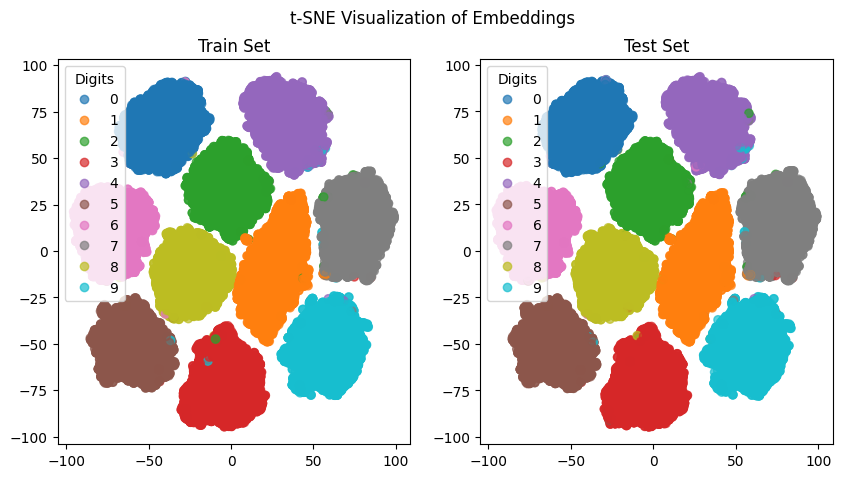

In [22]:
plt.figure(figsize=(10, 5))
plt.suptitle("t-SNE Visualization of Embeddings")

plt.subplot(1, 2, 1)
scatter = plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=train_labels.numpy(), cmap="tab10", alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title("Train Set")

plt.subplot(1, 2, 2)
scatter = plt.scatter(test_tsne[:, 0], test_tsne[:, 1], c=test_labels.numpy(), cmap="tab10", alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title("Test Set")

plt.show()

## Summary

In this tutorial, we implemented the triplet loss function with two online mining strategies called batch-all and batch-hard. We discussed the importance of triplet mining strategies and best practices for training a network with triplet loss. We trained a Siamese network on the MNIST dataset using the triplet loss function and evaluated the network using k-NN search and t-SNE visualization. The results showed that the network was able to learn meaningful representations of the input images, as evidenced by the high accuracy of the k-NN search and the clear separation of classes in the t-SNE visualization.